<a href="https://colab.research.google.com/github/dianabutch023/IS4487/blob/main/lab10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IS 4487 Lab 10

## Outline

Repeat exercises from Lab 9, but with the *Air Quality Daily AQI* dataset.

Pull the latest "Daily AQI by County" file from this link: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

You have two choices for target variable:
- *CATEGORY*, indicating if the air is healthy.  
- *AQI", which is the value of the air quality index

You can focus on either the entire country, split the country in regions, or focus on just one area (ex. Utah).   You can reduce noise by aggregating the data to the month of season level.   

Can you predict the category based on the location and time of year?  

The AQI is divided into six categories:

*Air Quality Index*

|(AQI) Values	|Levels of Health Concern	        |
|---------------|--------|
|0-50	        |Good	 |
|51-100	        |Moderate	 |
|101-150	    |Unhealthy for Sensitive Groups	|
|151 to 200	    |Unhealthy	 |
|201 to 300	    |Very Unhealthy	 |
|301 to 500	    |Hazardous	 |

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/Scripts/lab10_air_quality_fit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries

➡️ Assignment Tasks
- Load any necessary libraries

In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_graphviz # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn import tree


## Import Data into Dataframe

➡️ Assignment Tasks
- Import data from the air quality dataset into a dataframe (in GitHub go to Labs > DataSets)
- Describe or profile the dataframe

In [2]:
df = pd.read_csv('https://github.com/dianabutch023/IS4487/blob/main/daily_aqi_by_county_2024.csv?raw=true')
print(df.describe())

          State Code    County Code            AQI  Number of Sites Reporting
count  117042.000000  117042.000000  117042.000000              117042.000000
mean       30.123956      82.012107      39.806206                   1.847192
std        16.060506      97.931151      17.960383                   2.177259
min         1.000000       1.000000       0.000000                   1.000000
25%        17.000000      23.000000      31.000000                   1.000000
50%        30.000000      59.000000      39.000000                   1.000000
75%        42.000000     109.000000      48.000000                   2.000000
max        80.000000     810.000000    1322.000000                  33.000000


In [5]:
print(df)

       State Name county Name  State Code  County Code        Date  AQI  \
0         Alabama     Baldwin           1            3  2024-01-03   41   
1         Alabama     Baldwin           1            3  2024-01-04   38   
2         Alabama     Baldwin           1            3  2024-01-05   44   
3         Alabama     Baldwin           1            3  2024-01-06    7   
4         Alabama     Baldwin           1            3  2024-01-07   29   
...           ...         ...         ...          ...         ...  ...   
117037    Wyoming    Washakie          56           43  2024-06-26   33   
117038    Wyoming    Washakie          56           43  2024-06-27   23   
117039    Wyoming    Washakie          56           43  2024-06-28    4   
117040    Wyoming    Washakie          56           43  2024-06-29    7   
117041    Wyoming    Washakie          56           43  2024-06-30   13   

       Category Defining Parameter Defining Site  Number of Sites Reporting  
0          Good      

## Prepare Data

➡️ Assignment Tasks
- Create one dummy variable (true/false) for each of the Defining Parameter values    
- Create variables for month and season
- Perform any other data cleanup needed (remove outliers, nulls, etc.)
- Select the data you would like to use in the model.  If you aggregate data, you will have to decide whether to use the min, max or mean value for AQI

In [9]:
# cleaning data
#delete rows with outlier data; put it in a new dataframe
df_clean = df[(df['State Code'] < 51) & (df['AQI'] < 500) & (df['State Name'] == "Montana")]

#delete any rows with missing values in the clean dataframe
df_clean = df_clean.dropna()

df_clean.describe()

,State Code,County Code,AQI,Number of Sites Reporting
count,1812.0,1812.000000,1812.000000,1812.000000
mean,30.0,51.864238,32.272627,1.341611
std,0.0,31.197511,18.026230,0.778487
min,30.0,1.000000,0.000000,1.000000
25%,30.0,29.000000,18.000000,1.000000
50%,30.0,41.000000,33.000000,1.000000
75%,30.0,81.000000,43.000000,1.000000
max,30.0,111.000000,116.000000,4.000000


In [13]:
# Create month and season variables
df_clean['Date'] = pd.to_datetime(df_clean['Date'])
df_clean['Month'] = df_clean['Date'].dt.month

# Define a function to determine the season based on the month
df_clean.loc[df_clean['Month'] == 'January'] = "0"
df_clean.loc[df_clean['Month'] == 'February'] = "1"
df_clean.loc[df_clean['Month'] == 'March'] = "2"
df_clean.loc[df_clean['Month'] == 'April'] = "3"
df_clean.loc[df_clean['Month'] == 'May'] = "4"
df_clean.loc[df_clean['Month'] == 'June'] = "5"
df_clean.loc[df_clean['Month'] == 'July'] = "6"
df_clean.loc[df_clean['Month'] == 'August'] = "7"
df_clean.loc[df_clean['Month'] == 'September'] = "8"
df_clean.loc[df_clean['Month'] == 'October'] = "9"
df_clean.loc[df_clean['Month'] == 'November'] = "10"
df_clean.loc[df_clean['Month'] == 'December'] = "11"


In [15]:
# Define a function to determine the season based on the month
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_clean['Season'] = df_clean['Month'].apply(assign_season)

In [20]:
# Group by season and calculate the mean AQI
seasonal_aqi = df_clean.groupby('Season')['AQI'].mean()
seasonal_aqi

,AQI
Season,
Spring,29.243243
Summer,2.000000
Winter,34.222022


## Create Model

➡️ Assignment Tasks
- Create either one of these two models:
    - a simple linear regression to predict AQI based on as many variables as you can use or derive.  (for example, sklearn LinearRegression)
    - a classification tree to predict CATEGORY
- Visualize the correlation between the target variable and at least one of the independent variables

Mean Squared Error: 260.03672418333963
R-squared: -0.012978360316537207


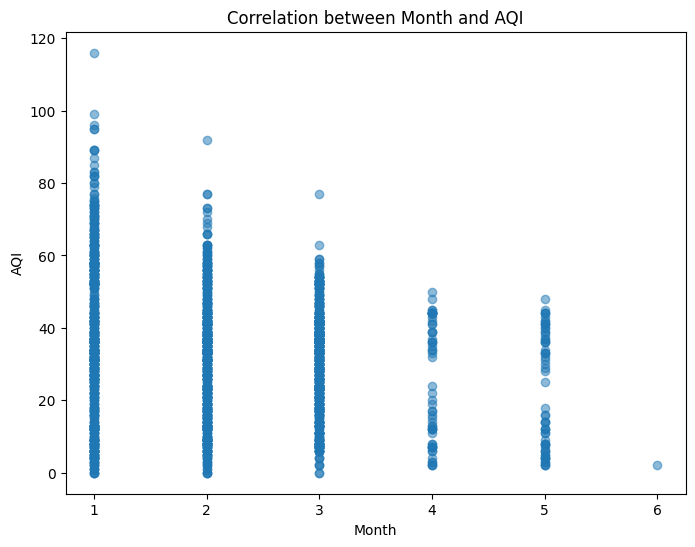

In [21]:
# prompt: create a linear regression to predict AQI

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the data for linear regression
features = ['Month']  # Add other relevant features
target = 'AQI'

X = df_clean[features]
y = df_clean[target]

# Convert categorical features to numerical using one-hot encoding (if needed)
X = pd.get_dummies(X, columns=['Month'], drop_first=True)


# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Visualize the correlation (example with 'Month')
plt.figure(figsize=(8, 6))
plt.scatter(df_clean['Month'], df_clean['AQI'], alpha=0.5)  # Use your actual feature
plt.xlabel("Month")
plt.ylabel("AQI")
plt.title("Correlation between Month and AQI")
plt.show()

## Make a prediction

➡️ Assignment Tasks
- What would you predict the average AQI to be in the month of January?  

In [23]:
# Create a DataFrame for January prediction
january_prediction = pd.DataFrame({'Month': [0]})
january_prediction = pd.get_dummies(january_prediction, columns=['Month'], drop_first=True)

# Align columns with training data
january_prediction = january_prediction.reindex(columns=X.columns, fill_value=0)

# Make the prediction
predicted_aqi = model.predict(january_prediction)

print(f"The predicted average AQI for January is: {predicted_aqi[0]}")

The predicted average AQI for January is: 38.16851441241684


## OPTIONAL: Compare Air Quality

➡️ Assignment Tasks
- Download the data from a year 20 years prior, using this website: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI
- Append the new data to the previous dataframe
- Use the year as a variable in your regression.  Is year a significant factor in predicting AQI?

In [ ]:
#import, append and create new model